# AutoClassifier

<p>This notebook describes the development of a system that can perform auto data cleaning, dimensionality reduction, training, and testing of several classifiers for a single class classification problem. The motivation behind creating this product was to demonstrate the value that data-driven methods can bring with very little initial investment. The auto classifier system can even handle text using natural language processing. However, three assumptions are made for the dataset: 1) all text columns (that are not categorical in nature) have been combined into a single column, 2) all other columns can be converted into category, float, and/or int, 3) the class label column is the last column of the dataset.  </p> 

<p>The AutoClassifier will perform the following functions:
 <ol>
  <li>Conversion of qualified features to category variables</li>
  <li>Feature selection using LASSO (optional)</li>
  <li>Vectorizing text (optional)</li>
  <li>Transformation to integer representation</li>
  <li>Fitting and hyperparameter optimization of several 'shallow' classifiers</li>
  <li>Fitting DNN model</li>
  <li>Saving and/or loading model to/from external files </li>
</ol> 

The AutoClassifier requires minimal pre-processing of the data and provides a quick and easy to use front end for users.
</p>


## AutoClassifier used for auto credit card approval - case study description

<p>This case study focuses on building an automatic credit card approval predictor the AutoClassifier. The Credit Approval Data Set from the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval"> UCI Machine Learning Repository </a>is used as an example dataset to demonstrate the methodology. Although the features labels are sanitized to maintain anonymity, expert opinions suggest that the feature labels may be: <code>Gender, Age, Debt, Married_status, BankCustomer, EducationLevel, Ethnicity, YearsEmployed, NoPriorDefault, Employed, CreditScore, DriversLicense, Citizen, ZipCode, Income</code> and <code> ApprovalStatus.</code></p>

<p>Credit card approval is a perfect case study for applied machine learning since the application approval process can be easily framed as a classification problem. The underlying pattern that differentiates between trustworthy customers and unreliable customers can be ascertained through the customer's credit and personal details. The conventional system for approvals were subjective and based on the bank manager's experience. Using machine learning, this subjective judgement can be supplemented with quantitave metrics that can lead to faster and more accurate approval processes. </p>




<p><sub>Sources:</sub><br>    
<sub>Data: Credit Approval Data Set, UCI Machine Learning Repository</sub><br>



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

df_all = pd.read_csv('../dat/cc_approvals_text.csv', na_values='?')
text_col = 'Tweet' #Column header that contains text 

df_all.head()
# data includes various features that are considered before 
# approving an individual’s credit card application. 
# The last column is the Approval Status. 

,Gender,Age,Debt,Married_status,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,NoPriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Tweet,ApprovalStatus
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,202.0,0,"#Amazon to unplug ""aStore"" affiliate's stores ...",+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,43.0,560,$SPY Bada Bing Bada Boom the FLUSH!! $SPX $QQQ...,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,280.0,824,Shorted $spy and $qqq here after taking hefty ...,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,100.0,3,@JESMCT hey $amzn finally picking up!! How hav...,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,120.0,0,"$AMZN isn't the real problem with the ""death o...",+


## Data cleaning and pre-processing
As can be seen, the dataset requires some cleaning before it can be used for any exploratory analysis. 

In [2]:
def convert_cat_cols(df, cat_var_limit=10, verbose=False):                
    """
    Converts columns with a small amount of unique values that are of
    type Object into categorical variables.
    Number of unique values defined by cat_var_limit
    """
    cat_var_true = df.apply(lambda x: 
                            len(x.value_counts()) < cat_var_limit)
    object_type_true = df.apply(lambda x: 
                         x.value_counts().index.dtype == 'O')
    if cat_var_true[object_type_true].any():
        df[cat_var_true[object_type_true].index] = \
        df[cat_var_true[object_type_true].index].astype('category')
        if verbose:
            print(df[cat_var_true[object_type_true].index].describe())
    return df

def impute_most_freq(df):
    """
    Imputes the most frequent value in place of NaN's
    """
    most_freq = df.apply(lambda x: x.value_counts().index[0])
    return df.fillna(most_freq)


df = df_all.drop([text_col], axis=1) #saving all non text columns
df = convert_cat_cols(df, 10)
df = impute_most_freq(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
Gender             690 non-null category
 Age               690 non-null float64
 Debt              690 non-null float64
 Married_status    690 non-null category
 BankCustomer      690 non-null category
 EducationLevel    690 non-null category
 Ethnicity         690 non-null category
 YearsEmployed     690 non-null float64
 NoPriorDefault    690 non-null category
 Employed          690 non-null category
 CreditScore       690 non-null int64
 DriversLicense    690 non-null category
 Citizen           690 non-null category
 ZipCode           690 non-null float64
 Income            690 non-null int64
ApprovalStatus     690 non-null category
dtypes: category(10), float64(4), int64(2)
memory usage: 41.1 KB


All data cleaning is done. Next step is to perform preprocessing of the dataset for insertion into the SciKit library functions which require numeric values. We'll convert our dataset into a binary integer representation using pd.get_dummies as well as a 0 - n_class-1 integer representation using the Scikit Transformer LabelEncoder

In [3]:
df_bin = pd.get_dummies(df, drop_first=True) 
#Converts category variables into a multicolumn binary integer 
#representation for each unique value

def convert_str_int_labels(df):
    """
    Converts columns with factors into integer representation
    """
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df = df.apply(lambda x: le.fit_transform(x))
    return df

df[df.select_dtypes(include=['object']).columns] = \
convert_str_int_labels(df.select_dtypes(include=['object'])) 
#Transforms an object variable column into a integer variable column

print(df_bin.info(),'\n',df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 38 columns):
 Age                  690 non-null float64
 Debt                 690 non-null float64
 YearsEmployed        690 non-null float64
 CreditScore          690 non-null int64
 ZipCode              690 non-null float64
 Income               690 non-null int64
Gender_b              690 non-null uint8
 Married_status_u     690 non-null uint8
 Married_status_y     690 non-null uint8
 BankCustomer_gg      690 non-null uint8
 BankCustomer_p       690 non-null uint8
 EducationLevel_c     690 non-null uint8
 EducationLevel_cc    690 non-null uint8
 EducationLevel_d     690 non-null uint8
 EducationLevel_e     690 non-null uint8
 EducationLevel_ff    690 non-null uint8
 EducationLevel_i     690 non-null uint8
 EducationLevel_j     690 non-null uint8
 EducationLevel_k     690 non-null uint8
 EducationLevel_m     690 non-null uint8
 EducationLevel_q     690 non-null uint8
 EducationLevel_r     690 

## Text cleaning and vectorization

<p>The text column will now be tokenized and converted into a corpus statistic, in this case using Tf-Idf and n-grams.</p> 

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer 

def clean_text(text_series):
    """
    Cleans a column of Tweets. Removes all special characters, 
    websites, mentions.
    """
    from re import sub as resub
    text_series = text_series.apply(
         lambda x:resub(
                "[^A-Za-z0-9 ]+|(\w+:\/\/\S+)|htt", " ", x)
                     ).str.strip().str.lower()
    return text_series

df_all[text_col] = clean_text(df_all[text_col])
text_proc_pipe = TfidfVectorizer(max_features=100, ngram_range=(1,2), 
                                 stop_words='english')
text_numeric_matrix = text_proc_pipe.fit_transform(df_all[text_col])
df_all[text_col].head(10)


0    amazon to unplug  astore  affiliate s stores o...
1    spy bada bing bada boom the flush   spx  qqq  ...
2    shorted  spy and  qqq here after taking hefty ...
3    jesmct hey  amzn finally picking up  how have ...
4    amzn isn t the real problem with the  death of...
5    web stock buzz   amzn  aapl  qcom  fcx  bby  0...
6    nicole1515  veedub78  ulta is as  amzn immune ...
7    this is funny rt  amzn is actually the weakest...
8    rt seekingalpha  6 dividend yields you need   ...
9    price returns vs expected daily move  nflx  sf...
Name: Tweet, dtype: object

## Splitting into train and test sets with auto feature selection
<p>With all numeric data, the next data-prep step will be to split the data into a training set and testing set. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then apply the scaling.</p>
<p> We will also performs feature selection on the dataframe. Feature selection is performed using the LASSO weight shrinking process. Features with coefficients that are around 0 are then rejected.</p>

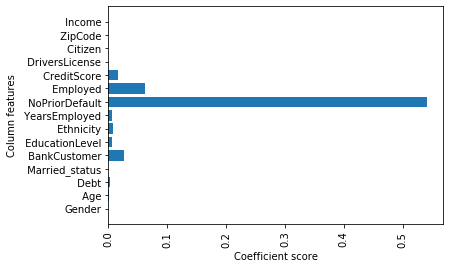

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

def feat_select(df, text_mat=None, test_size_var=0.3, 
                alpha_space=np.linspace(0.01,0.02,20), 
                random_state_var=21, use_feat_select=True, plot=True):
    """
    Performs feature selection on a dataframe with a single target 
    variable and n features. Test train split is also performed and only 
    splits of selected features are returned. Feature selection performed 
    using LASSO weight shrinking.
    """
    x_train, x_test, y_train, y_test = train_test_split(
        df.iloc[:,:-1], df.iloc[:,-1], test_size=test_size_var, 
        random_state=random_state_var, stratify=df.iloc[:,-1])

    if use_feat_select:
        param_grid = {'alpha': alpha_space}
        lasso_gcv = GridSearchCV(Lasso(normalize=False), param_grid, cv=5,
                                 n_jobs=-1, iid=True)
        lasso_coeffs = lasso_gcv.fit(x_train, y_train).best_estimator_.coef_
        if plot:
            plt.barh(y=range(len(df.columns[:-1])),width=np.abs(lasso_coeffs)
                     ,tick_label=df.columns[:-1].values)
            plt.ylabel('Column features')
            plt.xlabel('Coefficient score')
            plt.xticks(rotation=90)
            plt.show()
        select_feats = df.columns[:-1][np.abs(lasso_coeffs) > 0].values
        x_train = x_train.loc[:,select_feats]
        x_test = x_test.loc[:,select_feats]
    
    if text_mat is not None:
        # Text data is concatenated here if present
        x_train = np.concatenate((x_train.values,text_mat[x_train.index,:]),axis=1)
        x_test = np.concatenate((x_test.values,text_mat[x_test.index,:]),axis=1)
    else:
        x_train = x_train.values
        x_test = x_test.values
    
    return x_train, x_test, y_train.values, y_test.values


x_train, x_test, y_train, y_test = feat_select(
    df, text_numeric_matrix.toarray(), use_feat_select=True, plot=True)

## Creating a transformation and analysis pipeline

The dataset can now be rescaled so that no feature can artificially bias the analysis. In this case, no specialized feature engineering is performed and all the feature variables will be rescaled broadly. <br>
Both the binary integer representation and the non-binary integer representation will be tested. <br>
<strong> Note 1: better scores can be expected from intelligently rescaling the data. For example, age can be standardized while credit scores can be rescaled between 0 and -1.  <br>
Note 2: The above preprocessing functions can be integrated into the pipeline object using FunctionTransformer.
</strong>

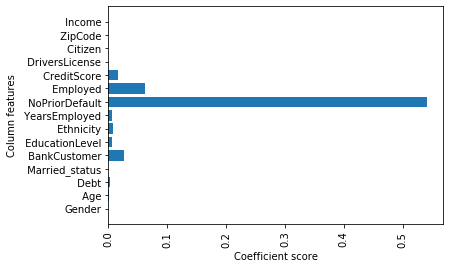


Analysis for : logreg
{'logreg__C': 1.2}
   mean_test_score              params
0         0.850932  {'logreg__C': 0.8}
1         0.855072    {'logreg__C': 1}
2         0.859213  {'logreg__C': 1.2}
3         0.857143  {'logreg__C': 1.4}
The score for logreg is 0.8405797101449275

Analysis for : knnstep
{'knnstep__n_neighbors': 15}
    mean_test_score                        params
0          0.815735   {'knnstep__n_neighbors': 3}
1          0.813665   {'knnstep__n_neighbors': 4}
2          0.824017   {'knnstep__n_neighbors': 5}
3          0.819876   {'knnstep__n_neighbors': 6}
4          0.826087   {'knnstep__n_neighbors': 7}
5          0.826087   {'knnstep__n_neighbors': 8}
6          0.830228   {'knnstep__n_neighbors': 9}
7          0.830228  {'knnstep__n_neighbors': 10}
8          0.824017  {'knnstep__n_neighbors': 11}
9          0.830228  {'knnstep__n_neighbors': 12}
10         0.830228  {'knnstep__n_neighbors': 13}
11         0.832298  {'knnstep__n_neighbors': 14}
12         0.8364

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = feat_select(
    df, text_numeric_matrix.toarray(), use_feat_select=True, plot=True)

scaler = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
         ('Scaler', Normalizer()),\
          ('Scaler', StandardScaler())]

classifiers = [('logreg', LogisticRegression(solver='lbfgs', max_iter=1000)),\
        ('knnstep', KNeighborsClassifier()),\
        ('svcstep', SVC(gamma='scale')),\
         ('gradbooststep', GradientBoostingClassifier(subsample=.8))]

parameters = {'logreg':{'logreg__C': [0.8,1,1.2,1.4]} ,\
              'knnstep':{'knnstep__n_neighbors': np.arange(3,16)},\
              'svcstep':{'svcstep__C': [0.5,1,1.5,2,2.5,2.6]},\
             'gradbooststep':{'gradbooststep__max_depth': [2,3,4,5],\
                              'gradbooststep__n_estimators': \
                              [40,60,80,100]}} 

model_dict = {}

for clf in classifiers:
    pipeline = Pipeline([scaler[0],clf])
    print('\nAnalysis for : ' + clf[0])
    gcv = GridSearchCV(pipeline, param_grid=parameters[clf[0]], cv=5, 
                       iid=True)
    gcv.fit(x_train,y_train)
    model_dict[clf[0]] = gcv
    print(gcv.best_params_)
    print(pd.DataFrame(gcv.cv_results_)[['mean_test_score','params']])
    print('The score for ' + clf[0] + ' is ' + str(gcv.score(x_test,y_test))) 
    

A similar analysis will now be done on the binary integer representation dataset.

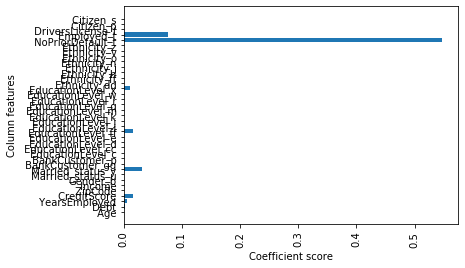


Analysis for : logreg
{'logreg__C': 0.8}
   mean_test_score              params
0         0.859213  {'logreg__C': 0.8}
1         0.855072    {'logreg__C': 1}
2         0.850932  {'logreg__C': 1.2}
3         0.844720  {'logreg__C': 1.4}
The score for logreg is 0.8647342995169082

Analysis for : knnstep
{'knnstep__n_neighbors': 10}
    mean_test_score                        params
0          0.821946   {'knnstep__n_neighbors': 3}
1          0.819876   {'knnstep__n_neighbors': 4}
2          0.817805   {'knnstep__n_neighbors': 5}
3          0.826087   {'knnstep__n_neighbors': 6}
4          0.817805   {'knnstep__n_neighbors': 7}
5          0.826087   {'knnstep__n_neighbors': 8}
6          0.826087   {'knnstep__n_neighbors': 9}
7          0.830228  {'knnstep__n_neighbors': 10}
8          0.819876  {'knnstep__n_neighbors': 11}
9          0.824017  {'knnstep__n_neighbors': 12}
10         0.826087  {'knnstep__n_neighbors': 13}
11         0.826087  {'knnstep__n_neighbors': 14}
12         0.8302

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

x_train, x_test, y_train, y_test = feat_select(df_bin,text_numeric_matrix.toarray(),use_feat_select=True,plot=True)

scaler = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
         ('Scaler', Normalizer()),\
          ('Scaler', StandardScaler())]

classifiers = [('logreg', LogisticRegression(solver='lbfgs', 
                                             max_iter=1000)),\
        ('knnstep', KNeighborsClassifier()),\
        ('svcstep', SVC(gamma='scale')),\
         ('gradbooststep', GradientBoostingClassifier(subsample=.8))]

parameters = {'logreg': {'logreg__C': [0.8,1,1.2,1.4]} ,\
              'knnstep': {'knnstep__n_neighbors': np.arange(3,16)},\
              'svcstep': {'svcstep__C': [0.5,1,1.5,2,2.5,2.6]},\
             'gradbooststep': {'gradbooststep__max_depth': [2,3,4,5],\
                              'gradbooststep__n_estimators': \
                              [40,60,80,100]}} 

model_dict = {}

for clf in classifiers:
    pipeline = Pipeline([scaler[0],clf])
    print('\nAnalysis for : ' + clf[0])
    gcv = GridSearchCV(pipeline, param_grid=parameters[clf[0]], cv=5, 
                       iid=True)
    gcv.fit(x_train,y_train)
    model_dict[clf[0]] = gcv
    print(gcv.best_params_)
    print(pd.DataFrame(gcv.cv_results_)[['mean_test_score','params']])
    print('The score for ' + clf[0] + ' is ' + str(gcv.score(x_test,y_test))) 

## Exploring Deep Neural Networks (DNNs) for classification
<p> In this particular case, it would seem that we do not have enough data to satisfactorily train a DNN. However, we will build a 6 layer DNN with a ramped layer node architecture for comparison with the <emph>'shallow'</emph> learning case.</p> The binary integer representation dataset will be used without feature selection to maximize data use.

In [8]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

x_train, x_test, y_train, y_test = feat_select(
    df_bin, text_numeric_matrix.toarray(), use_feat_select=False, 
    plot=False)

steps = ('Scaler', MinMaxScaler(feature_range=(-1, 1)))
steps_norm = ('Scaler', Normalizer())
steps_stand = ('Scaler', StandardScaler())

scaler = steps[1]
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

n_cols = x_train.shape[-1]

model = Sequential()
model.add(Dense(5, activation='relu', input_shape=(n_cols,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

early_stop_monitor  = EarlyStopping(patience=2)
model.compile (optimizer='adam',
               loss='categorical_crossentropy', metrics=['accuracy'])
train_dp_model = model.fit(x_train, pd.get_dummies(y_train).values,
                           validation_split = .2, epochs = 20, 
                           callbacks =[early_stop_monitor],
                           verbose=True)
print('Loss metrics: ' + str(train_dp_model.history['loss'][-1]))
pred_prob = model.predict(x_test)
accuracy_dp = np.sum((pred_prob[:,1]>=0.5)==y_test) / len(y_test)
print('Testing accuracy: ' + str(accuracy_dp))

Using TensorFlow backend.
W1110 18:31:33.717415  4436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1110 18:31:33.748692  4436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1110 18:31:33.748692  4436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1110 18:31:33.951794  4436 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1110 18:31:33.998696  4436 deprecation_wrapper.py:119

Train on 386 samples, validate on 97 samples
Epoch 1/20
386/386 [==============================] - 2s 6ms/step - loss: 0.6826 - acc: 0.4560 - val_loss: 0.6971 - val_acc: 0.5567
Epoch 2/20
386/386 [==============================] - 0s 121us/step - loss: 0.6585 - acc: 0.6554 - val_loss: 0.6877 - val_acc: 0.6598
Epoch 3/20
386/386 [==============================] - 0s 121us/step - loss: 0.6432 - acc: 0.7098 - val_loss: 0.6900 - val_acc: 0.6289
Epoch 4/20
386/386 [==============================] - 0s 121us/step - loss: 0.6264 - acc: 0.6969 - val_loss: 0.6699 - val_acc: 0.6804
Epoch 5/20
386/386 [==============================] - 0s 81us/step - loss: 0.5963 - acc: 0.7435 - val_loss: 0.6593 - val_acc: 0.6804
Epoch 6/20
386/386 [==============================] - 0s 121us/step - loss: 0.5587 - acc: 0.7746 - val_loss: 0.6342 - val_acc: 0.7010
Epoch 7/20
386/386 [==============================] - 0s 81us/step - loss: 0.5227 - acc: 0.7772 - val_loss: 0.5978 - val_acc: 0.7320
Epoch 8/20
386/386 [=

As we can see with results above, the accuracy of the DNN classifier appears to be quite close to the logistic regression classifier accuracy with minimal feature engineering and with comparatively very little data.

## AutoClassifier Backend Pipeline

Includes error handling using assertions and try/except clauses.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def convert_cat_cols(df, cat_var_limit=10, verbose=False):                
    """
    Converts columns with a small amount of unique values that are of
    type Object into categorical variables.
    Number of unique values defined by cat_var_limit
    """
    cat_var_true = df.apply(lambda x: 
                            len(x.value_counts()) < cat_var_limit)
    object_type_true = df.apply(lambda x: 
                         x.value_counts().index.dtype == 'O')
    if cat_var_true[object_type_true].any():
        df[cat_var_true[object_type_true].index] = \
        df[cat_var_true[object_type_true].index].astype('category')
        if verbose:
            print(df[cat_var_true[object_type_true].index].describe())
    return df

def impute_most_freq(df):
    """
    Imputes the most frequent value in place of NaN's
    """
    most_freq = df.apply(lambda x: x.value_counts().index[0])
    return df.fillna(most_freq)

def convert_str_int_labels(df):
    """
    Converts columns with factors into integer representation
    """
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df = df.apply(lambda x: le.fit_transform(x))
    return df

def clean_text(text_series):
    """
    Cleans a column of Tweets. Removes all special characters, 
    websites, mentions.
    """
    from re import sub as resub
    text_series = text_series.apply(
         lambda x:resub(
                "[^A-Za-z0-9 ]+|(\w+:\/\/\S+)|htt", " ", x)
                     ).str.strip().str.lower()
    return text_series

def feat_select(df, text_mat=None, test_size_var=0.3, 
                alpha_space=np.linspace(0.01,0.02,20), 
                random_state_var=21, use_feat_select=True, plot=True):
    """
    Performs feature selection on a dataframe with a single target 
    variable and n features. Test train split is also performed and only 
    splits of selected features are returned. Feature selection performed 
    using LASSO weight shrinking.
    """
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from sklearn.linear_model import Lasso
    
    x_train, x_test, y_train, y_test = train_test_split(
        df.iloc[:,:-1], df.iloc[:,-1], test_size=test_size_var, 
        random_state=random_state_var, stratify=df.iloc[:,-1])

    if use_feat_select:
        param_grid = {'alpha': alpha_space}
        lasso_gcv = GridSearchCV(Lasso(normalize=False), param_grid, cv=5,
                                 n_jobs=-1, iid=True)
        lasso_coeffs = lasso_gcv.fit(x_train, y_train).best_estimator_.coef_
        if plot:
            plt.barh(y=range(len(df.columns[:-1])), width=np.abs(lasso_coeffs),
                     tick_label=df.columns[:-1].values)
            plt.ylabel('Column features')
            plt.xlabel('Coefficient score')
            plt.xticks(rotation=90)
            plt.show()
        try:
            select_feats = df.columns[:-1][np.abs(lasso_coeffs) > 0].values
        except:
            print('Lasso Coefficients all turned out to be 0')
            print(' or could not be calculated. Check your')
            print(' dataset or switch off feature selection.')
                     
        x_train = x_train.loc[:,select_feats]
        x_test = x_test.loc[:,select_feats]
    
    if text_mat is not None:
        x_train = np.concatenate((x_train.values,text_mat[x_train.index,:]), axis=1)
        x_test = np.concatenate((x_test.values,text_mat[x_test.index,:]), axis=1)
    else:
        x_train = x_train.values
        x_test = x_test.values
    
    return x_train, x_test, y_train.values, y_test.values


def preprocess_block(df_all, text_col=None, cat_var_limit=10, bin_rep=1,
                     max_tfidf_features=100, ngram_range=(1,2),
                     use_feat_select=True, 
                     alpha_space=np.linspace(0.01,0.02,20), 
                     random_state_var=20, test_size_var=.3):
    """
    Preprocessing block: used to preprocess and transform the data columns
    ---------------------------------------------------------------------------
    -df_all (DataFrame): DataFrame with all the data, last column should be 
    target variable
    -text_col (str): name of the text column, default is None for no text columns
    -cat_var_limit (int): greatest number of unique values in a column to qualify 
    for conversion into a category column 
    -bin_rep (int): style of integer representation for category variables, 0 for 
    binary integer representation, 1 for 0 to nclass-1 representation
    -max_tfidf_features (int): maximum number of features after vectorizing text 
    column using tfidf metric
    -ngram_range (tuple): 2 tuple consisting of start and end point of ngram
    -use_feat_select (bool): True for applying feature selection using LASSO for 
    non-text columns
    -alpha_space (array of float): testing space for alpha parameter of LASSO
    -random_state_var (int): Random seed for train-test-split
    -test_size_var (float): ratio of test versus train split 
    ---------------------------------------------------------------------------
    """
    if text_col is not None:
        df = df_all.drop([text_col], axis=1) #All columns except text
    else:
        df = df_all
    
    df = impute_most_freq(convert_cat_cols(df,10))
    
    if bin_rep:
        try:
            df[df.select_dtypes(include=['category']).columns] = \
            convert_str_int_labels(df.select_dtypes(include=['category'])) 
            #Transforms a category variable column into an integer variable 
            #column
        except:
            print('No columns with category variables. Change bin_rep to 0')
    else:
        df = pd.get_dummies(df,drop_first=True) 
        #Converts category variables into a multicolumn binary integer 
        #representation for each unique value
    
    assert (df.notnull().all().all()), 'NaNs present in DataFrame' 
    
    if text_col is not None:
        from sklearn.feature_extraction.text import TfidfVectorizer 
        try:
            df_all[text_col] = clean_text(df_all[text_col])
        except:
            print('Cannot clean text, recheck text column')
        text_numeric_matrix = TfidfVectorizer(max_features=max_tfidf_features,
                                              ngram_range=(1,2), 
                                              stop_words='english')\
                              .fit_transform(df_all[text_col])
       
        return feat_select(df, text_numeric_matrix.toarray(), 
                           test_size_var=test_size_var, 
                           use_feat_select=use_feat_select, 
                           alpha_space=alpha_space, 
                           random_state_var=random_state_var, plot=True)
    else:
        return feat_select(df, use_feat_select=use_feat_select, 
                           test_size_var=test_size_var,
                           alpha_space=alpha_space, plot=True,
                           random_state_var=random_state_var)

    
def shallow_model(x_train, x_test, y_train, y_test, scaler_ch=0,
                  logreg_C=[0.8,1,1.2,1.4], knn_neigh=np.arange(3,16),
                  svc_c=[0.5,1,1.5,2,2.5,2.6], gb_max_depth=[2,3,4,5],
                  gb_n_est=[40,60,80,100], verbose=True, save=True,
                  model_file='Trained_shallow_models.sav'): 
    """
    This function will fit and test several shallow classfication models and 
    save them, models include:
    'logreg': Logistic Regression using the lbfgs solver
    'knnstep': K Nearest Neighbors
    'svcstep': Support Vector Classification model
    'gradbooststep': Gradient Boosted Classification Trees
    
    Scaling options include:
    MinMaxScaler between a range of -1 and 1
    Normalizer 
    StandardScaler
    
    The function will also run a 5 fold cross validated grid search for 
    hyperparameter optimization
    ---------------------------------------------------------------------------
    -x_train (DataFrame or ndarray): Training data consisting of features   
    -x_test (DataFrame or ndarray): Testing data consisting of features
    -y_train (DataFrame, Series or ndarray): Training data for predictions 
    (single class only)   
    -y_train (DataFrame, Series or ndarray): Testing data for predictions 
    (single class only)   
    -scaler_ch (int): Decides which scaler to use, 0 for MinMaxScaler, 1 for 
    Normalizer, 2 for StandarScaler
    -logreg_C (list of float): Hyperparameter space for C to be used in the 
    Log Reg Classifier
    -knn_neigh (list of int): Hyperparameter space for number of neighbors to 
    be used in the KNN Classifier
    -svc_c (list of float): Hyperparameter space for C to be used in the 
    Support Vector Classifier
    -gb_max_depth (list of int): Hyperparameter space for max depth to be used 
    in Gradient Boosted Classifier Trees
    -gb_n_est (list of int): Hyperparameter space for number of estimators to 
    be used in Gradient Boosted Classifier Trees
    -verbose (bool): Prints out details if True
    -save (bool): Switch for saving the trained models in an external data file
    -model_file (str): Filename for storing all the trained models
    ---------------------------------------------------------------------------
    """   
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.svm import SVC
    import pickle
    
    scaler = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
             ('Scaler', Normalizer()), ('Scaler', StandardScaler())]

    classifiers = [('logreg', LogisticRegression(solver='lbfgs', 
                                                 max_iter=1000)),\
        ('knnstep', KNeighborsClassifier()),\
        ('svcstep', SVC(gamma='scale')),\
         ('gradbooststep', GradientBoostingClassifier(subsample=.8))]

    parameters = {'logreg': {'logreg__C': logreg_C} ,\
              'knnstep': {'knnstep__n_neighbors': knn_neigh},\
              'svcstep': {'svcstep__C': svc_c},\
             'gradbooststep': {'gradbooststep__max_depth': gb_max_depth,\
                              'gradbooststep__n_estimators': \
                              gb_n_est}} 
    model_dict = {}

    for clf in classifiers:
        pipeline = Pipeline([scaler[scaler_ch], clf])
        print('\nAnalysis for : ' + clf[0])
        gcv = GridSearchCV(pipeline, param_grid=parameters[clf[0]],
                           cv=5, iid=True)
        gcv.fit(x_train, y_train)
        model_dict[clf[0]] = (gcv, gcv.score(x_test, y_test))
        if verbose:
            print('The best parameters for: ' + clf[0] + ' are :' +
                  str(gcv.best_params_))
            print(pd.DataFrame(gcv.cv_results_)
                  [['mean_test_score','params']])
        print('The score for ' + clf[0] + ' is ' + 
              str(gcv.score(x_test, y_test))) 
    
    if save:
        pickle.dump(model_dict, open(model_file, 'wb'))
    
    return model_dict


def deep_model(x_train, x_test, y_train, y_test, scaler_ch=0, 
               patience_val=2, validation_split_val=.2, epochs_val=20,
               verbose=True, save=True, model_file='Trained_deep_model.h5'):
    """
    This function will fit and test a Deep Neural Network that uses ReLu 
    and softmax activation functions. It also uses an EarlyStopper
    
    Scaling options include:
    MinMaxScaler between a range of -1 and 1
    Normalizer 
    StandardScaler
    
    ---------------------------------------------------------------------
    -x_train (DataFrame or ndarray): Training data consisting of features   
    -x_test (DataFrame or ndarray): Testing data consisting of features
    -y_train (DataFrame, Series or ndarray): Training data for predictions 
    (single class only)   
    -y_train (DataFrame, Series or ndarray): Testing data for predictions 
    (single class only)    
    -scaler_ch (int): Decides which scaler to use, 0 for MinMaxScaler, 
    1 for Normalizer, 2 for StandarScaler
    -patience_val (int): Number of epochs to monitor before exiting 
    training if no major changes in accuracy occurs
    -validation_split_val (float): ratio of split of dataset for testing 
    purposes
    -epochs_val (int): Max number of epochs to train
    -verbose (bool): Model training details will be printed out if True
    -save (bool): Switch for saving the trained models in an external data 
    file
    -model_file (str): Filename for storing the trained model. Must be H5 
    extension
    ----------------------------------------------------------------------
    """   
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import StandardScaler
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping
    
    scaler_list = [('Scaler', MinMaxScaler(feature_range=(-1, 1))),\
              ('Scaler', Normalizer()),\
              ('Scaler', StandardScaler())]

    scaler = scaler_list[scaler_ch][1]
    
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.fit_transform(x_test)

    n_cols = x_train.shape[-1]

    model = Sequential()
    model.add(Dense(5, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2,activation='softmax'))

    early_stop_monitor = EarlyStopping(patience=patience_val)
    model.compile (optimizer='adam',
                   loss= 'categorical_crossentropy',
                   metrics=['accuracy'])
    train_dp_model=model.fit(x_train, pd.get_dummies(y_train).values,
                             validation_split=validation_split_val, 
                             epochs = epochs_val,
                             callbacks =[early_stop_monitor],
                             verbose=verbose)

    print('Loss metrics: ' + str(train_dp_model.history['loss'][-1]))
    
    pred_prob = model.predict(x_test)
    accuracy_dp = np.sum((pred_prob[:,1]>=0.5)==y_test) / len(y_test)
    print('Testing accuracy: ' + str(accuracy_dp)) 
    
    if save:
        model.save(model_file)   
    
    return model


def load_model(type='shallow', filename='Trained_shallow_models.sav', 
               clf='logreg'):
    """
    This function is used to load a previously saved trained model. 
    The model will have been saved in an external file.
    
    ---------------------------------------------------------------------
    -type (str): 'shallow' to load a trained shallow model, 
    'deep' to load a trained deep model
    -filename (str): Name of the file with the saved model
    -clf (str): Only used for retrieving shallow models, this is the label 
    of the classifier -
    'logreg': Logistic Regression using the lbfgs solver
    'knnstep': K Nearest Neighbors
    'svcstep': Support Vector Classification model
    'gradbooststep': Gradient Boosted Classification Trees
    ---------------------------------------------------------------------
    """
    assert (type == 'shallow' or type == 'deep'), 'Wrong input for type' 
    if type == 'shallow':
        import pickle
        try:
            model_dict = pickle.load(open(filename, 'rb'))
        except:
            print('Could not load file. Check filename.')
        for label, model in model_dict.items():
            print(label + ' score is: ' + str(model[1]))
        return model_dict[clf][0]
    
    elif type == 'deep':
        from keras.models import load_model 
        try:
            model = load_model(filename)
        except:
            print('Could not load file. Check filename.')
        print('Model Summary: ')
        model.summary()
        return model

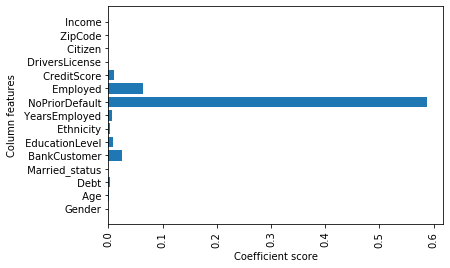




Analysis for : logreg
The best parameters for: logreg are :{'logreg__C': 0.8}
   mean_test_score              params
0         0.850932  {'logreg__C': 0.8}
1         0.848861    {'logreg__C': 1}
2         0.844720  {'logreg__C': 1.2}
3         0.844720  {'logreg__C': 1.4}
The score for logreg is 0.8695652173913043

Analysis for : knnstep
The best parameters for: knnstep are :{'knnstep__n_neighbors': 15}
    mean_test_score                        params
0          0.836439   {'knnstep__n_neighbors': 3}
1          0.826087   {'knnstep__n_neighbors': 4}
2          0.836439   {'knnstep__n_neighbors': 5}
3          0.840580   {'knnstep__n_neighbors': 6}
4          0.840580   {'knnstep__n_neighbors': 7}
5          0.832298   {'knnstep__n_neighbors': 8}
6          0.836439   {'knnstep__n_neighbors': 9}
7          0.834369  {'knnstep__n_neighbors': 10}
8          0.844720  {'knnstep__n_neighbors': 11}
9          0.836439  {'knnstep__n_neighbors': 12}
10         0.840580  {'knnstep__n_neighb

In [10]:
df_all = pd.read_csv('../dat/cc_approvals_text.csv', na_values='?')
text_col = 'Tweet' #CSV column that is text 

x_train, x_test, y_train, y_test = preprocess_block(df_all,'Tweet')

_=shallow_model(x_train, x_test, y_train, y_test)

_=deep_model(x_train, x_test, y_train, y_test)

clf_shallow = load_model(clf='logreg')

clf_deep = load_model('deep','Trained_deep_model.h5')

print(clf_shallow.predict(x_test))
print(clf_deep.predict(x_test))


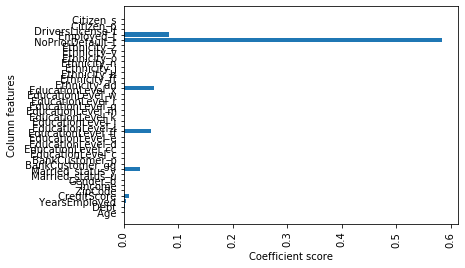





Analysis for : logreg
The best parameters for: logreg are :{'logreg__C': 0.8}
   mean_test_score              params
0         0.857143  {'logreg__C': 0.8}
1         0.850932    {'logreg__C': 1}
2         0.850932  {'logreg__C': 1.2}
3         0.850932  {'logreg__C': 1.4}
The score for logreg is 0.8599033816425121

Analysis for : knnstep
The best parameters for: knnstep are :{'knnstep__n_neighbors': 11}
    mean_test_score                        params
0          0.828157   {'knnstep__n_neighbors': 3}
1          0.848861   {'knnstep__n_neighbors': 4}
2          0.838509   {'knnstep__n_neighbors': 5}
3          0.848861   {'knnstep__n_neighbors': 6}
4          0.846791   {'knnstep__n_neighbors': 7}
5          0.846791   {'knnstep__n_neighbors': 8}
6          0.844720   {'knnstep__n_neighbors': 9}
7          0.844720  {'knnstep__n_neighbors': 10}
8          0.855072  {'knnstep__n_neighbors': 11}
9          0.846791  {'knnstep__n_neighbors': 12}
10         0.848861  {'knnstep__n_neigh

In [11]:
df_all = pd.read_csv('../dat/cc_approvals_text.csv',na_values='?')
df_all = df_all.drop(['Tweet'],axis=1)

x_train, x_test, y_train, y_test = preprocess_block(df_all, bin_rep=0)

_ = shallow_model(x_train, x_test, y_train, y_test)

_ = deep_model(x_train, x_test, y_train, y_test)

clf_shallow = load_model(clf='logreg')

clf_deep    = load_model('deep','Trained_deep_model.h5')

print(clf_shallow.predict(x_test))
print(clf_deep.predict(x_test))


## Conclusion

This notebook shows the development of an analysis and machine learning pipeline that can perform auto data cleaning, dimensionality reduction, training, and testing of several classifiers for a single class classification problem. This system was applied to a credit card application approval process as a case-study. <br>
The AutoClassifier performed the following operations: four shallow classifiers were tested with their hyperparameters tuned using a 5-fold cross-validated gridsearch. Additionally a 6 layer DNN classifier was also tested. The analysis showed that the KNN and logistic regression classifier trained on a binary integer representation dataset with feature selection outperformed the rest of the classifiers and exhibited a classification accuracy of around 86% on the test set. For better results, it is advised to engineer each feature column individually, especially features with high LASSO coefficient scores. <br>
The AutoClassifier provides the user a rapid analysis system for single class label classification problem. It works work very well as a demonstrator tool and for performing rapid analysis with minimal feature engineering. It is targeted towards users in industries that have yet not adopted ml based data driven systems to showcase the tremendous potential that it can bring to their workflow.  


